## Title: M4 Network Optimization Assignment

## Author: Leo Genders

## Date: 25 July 2024

## 2) Supply Chain Model Diagram

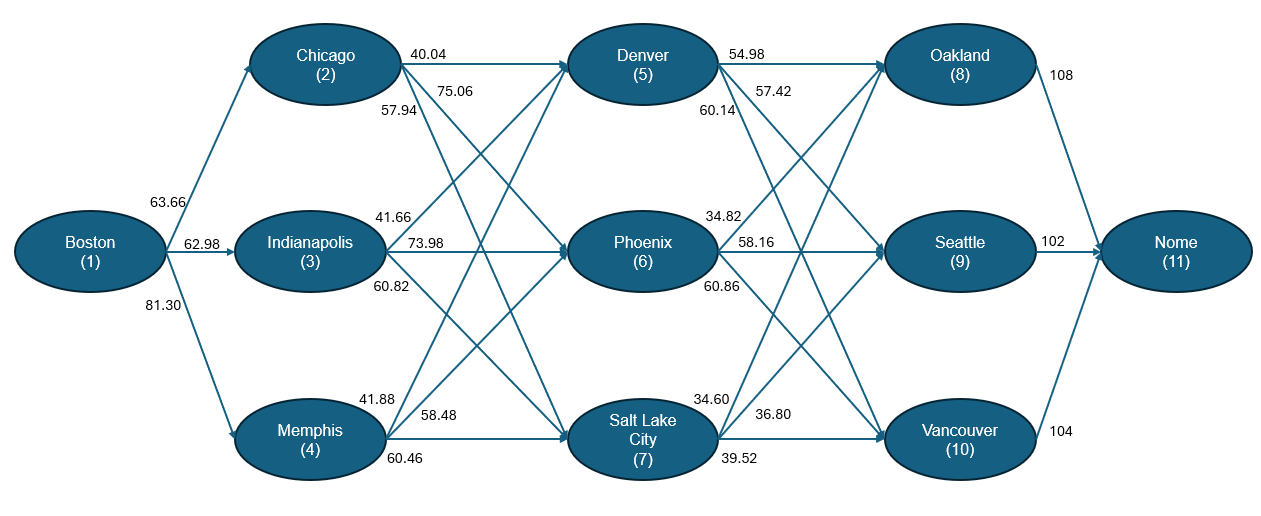

In [1]:
from IPython import display
display.Image("GE_supply_chain_model.png")

## 3) Greedy Algorithm

## Algorithm Steps
- Initialize
    - Adjacency set
    - path x
    - unvisited list u
- while x is incomplete:
    - for unvisited adjacent nodes do: \
            - add closest node to x \
            - remove closest node from u

Dictionary key values:
1: Boston
2: Chicago
3: Indianapolis
4: Memphis
5: Denver
6: Phoenix
7: Salt Lake City
8: Oakland
9: Seattle
10: Vancouver
11: Nome

## Greedy Heuristic for Shortest Path - GE Turbine Problem

In [2]:
# Node dictionary with adjacent nodes and times (in hours) with string values as the city
A = {
    'Boston': [['Chicago',63.66],['Indianapolis',62.98],['Memphis',81.30]],
    'Chicago': [['Denver',40.04],['Phoenix',75.06],['Salt Lake City',57.94]],
    'Indianapolis': [['Denver',41.66],['Phoenix',73.98],['Salt Lake City',60.82]],
    'Memphis': [['Denver',41.88],['Phoenix',58.48],['Salt Lake City',60.46]],
    'Denver': [['Oakland',54.98],['Seattle',57.42],['Vancouver',60.14]],
    'Phoenix': [['Oakland',34.82],['Seattle',58.16],['Vancouver',60.86]],
    'Salt Lake City': [['Oakland',34.60],['Seattle',36.80],['Vancouver',39.52]],
    'Oakland': [['Nome',108]],
    'Seattle': [['Nome',102]],
    'Vancouver': [['Nome',104]]
}

# Initialize parameters
## source
s = 'Boston'
## desintation
d = 'Nome'
## large number, larger than the sum of all times
M = 100000
## path
x = [s]
## unvisited nodes
u = ['Chicago','Indianapolis','Memphis','Denver','Phoenix','Salt Lake City','Oakland','Seattle','Vancouver',d]
## total time
total_time = 0


# loop until path reaches destination
while x[-1] != d:
    # reset closest time to a large number
    time = M
    # loop over nodes that are adjacent to the last node in the path
    for j in A[x[-1]]:
        # only consider unvisited nodes - referring to the index 0 position for the node
        if (j[0] in u):
            # choose the node that is closest
            if j[1] < time:
                # save its label
                k = j[0]
                # save its time
                time = j[1]
    # add closest node to the path
    x.append(k)
    # ...and remove it from the unvisited nodes list - working through the supply chain
    u.remove(k)
    # increment the total time
    total_time += time
    
# print the solution
print("The shortest path is: %s" % x)
print("The total travel time is %s hours." % total_time)

The shortest path is: ['Boston', 'Indianapolis', 'Denver', 'Oakland', 'Nome']
The total travel time is 267.62 hours.


## What is the path and what is the total travel time in hours?

Answer: The shortest path is: Boston to Indianapolis to Denver to Oakland to Nome. \
The total travel time is 267.62 hours.

## 4) Model Formulation

## Model Formulation

**Sets** \
$N$: set of cities {1,2,...,11}\
$A$: set of city pair arcs

**Parameters** \
$s$: vector of supply at each node \
$d$: vector of demand at each node \
$C$: matrix of times, where $c_{i,j}$ is the travel time from city $i$ to city $j$\
one 10-hour rest must occur every 11 hours of driving

**Decision Variables** \
$x_{i,j}$: = 1 if the path includes the arc $(i,j)$, = 0 otherwise

**Objective Function and Constraints** \
The optimization model is formulated as


\begin{equation*}
\begin{matrix}
\underset{x}{\min} & \underset{(i,j) \in A}{\sum}c_{i,j}x_{i,j} &\\
\textrm{s.t.} & \underset{i: (i,j) \in A}{\sum}x_{i,j} + s_j & = & \underset{k: (j,k) \in A}{\sum}x_{j,k} + d_j & \forall j \in N \\
& x_{i,j} & \leq & 0 & \forall (i,j) \in A \\
\end{matrix}
\end{equation*}

In [3]:
# initial node is the only node that has supply, all other nodes have 0 supply
# demand is such that the destination is the only node that has demand and is set to one, all others to 0

# i is where the flow is coming from on LHS
# j is where the flow is going to on RHS

## 5) Optimization Model

In [4]:
# trying to replace number values for nodes to city names
from gurobipy import *
import numpy as np
m = Model('GE_turbine_2')

# Sets and Parameters
## Set of cities, supply data, demand data
N, s, d = multidict({
    'Boston': [1,0],
    'Chicago': [0,0],
    'Indianapolis': [0,0],
    'Memphis': [0,0],
    'Denver': [0,0],
    'Phoenix': [0,0],
    'Salt Lake City': [0,0],
    'Oakland': [0,0],
    'Seattle': [0,0],
    'Vancouver': [0,0],
    'Nome': [0,1]})
## Set of city-city arcs, time data
A, c = multidict({
    ('Boston','Chicago'): 63.66,
    ('Boston','Indianapolis'): 62.98,
    ('Boston','Memphis'): 81.30,
    ('Chicago','Denver'): 40.04,
    ('Chicago','Phoenix'): 75.06,
    ('Chicago','Salt Lake City'): 57.94,
    ('Indianapolis','Denver'): 41.66,
    ('Indianapolis','Phoenix'): 73.98,
    ('Indianapolis','Salt Lake City'): 60.82,
    ('Memphis','Denver'): 41.88,
    ('Memphis','Phoenix'): 58.48,
    ('Memphis','Salt Lake City'): 60.46,
    ('Denver','Oakland'): 54.98,
    ('Denver','Seattle'): 57.42,
    ('Denver','Vancouver'): 60.14,
    ('Phoenix','Oakland'): 34.82,
    ('Phoenix','Seattle'): 58.16,
    ('Phoenix','Vancouver'): 60.86,
    ('Salt Lake City','Oakland'): 34.60,
    ('Salt Lake City','Seattle'): 36.80,
    ('Salt Lake City','Vancouver'): 39.52,
    ('Oakland','Nome'): 108,
    ('Seattle','Nome'): 102,
    ('Vancouver','Nome'): 104})


# Decision Variables
## Assignments (non-negativity caputred w/ lb)
x = m.addVars(A, name='arc', lb=0)
m.update()

# Objective Function
## Minimize total cost
m.setObjective(quicksum(c[i,j]*x[i,j] for (i,j) in A), GRB.MINIMIZE)
m.update()

# Constraints
## Flow balance, plural 'constraints' bc we are adding one for each node
# LHS is sum up over all values coming in for node j
# RHS is sum up over all values going out for node j
m.addConstrs(x.sum('*',j) + s[j] == x.sum(j, '*') + d[j] for j in N)
m.update()

# Solve and Print Solution
m.optimize()
print("\n\n")
for i,j in A:
    if x[i,j].x == 1:
        print("Travel from %s to %s." % (i,j))
print("\nThe total travel time is %s hours." % m.objval)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-03
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 5 5600X 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 11 rows, 24 columns and 48 nonzeros
Model fingerprint: 0x267ade65
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 6 rows and 6 columns
Presolve time: 0.00s
Presolved: 5 rows, 18 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0246000e+02   2.000000e+00   0.000000e+00      0s
       3    2.6040000e+02   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.604000000e+02



Travel from Boston to Chicag

**Answer: *The path is Boston to Chicago to Salt Lake City to Seattle to Nome. The total travel time is 260.4 hours.***

## 6) Business Interpretation and Sensitivity Analysis

**Question: How should GE transport the turbines to Nome?**

Answer: GE should transport by trucks from Boston to Indianapolis to Denver to Oakland. From Oakland, GE should use boats to travel to Nome if based on the Greedy Heuristic Shortest Path Model.

GE should transport by trucks from Boston to Chicago to Salt Lake City to Seattle. From Seattle, GE should use boats to travel to Nome if based on the Optimization Model.

**Question: How long should they expect it to take?**

Answer: GE should expect the travel to take 267.62 hours from Boston to Nome if using the Greedy Heuristic Shortest Path Model. \
GE should expect the travel to take 260.4 hours from Boston to Nome if using the Optimization Model. \

In my experience, if I only had the option to choose from the two models in this scenario, I would select the model with the shortest time (optimization model). However, I would also consider whether using the optimization model for the path selection, but adding the slower time from the greedy heuristic to be more realistic when presenting to leadership. For example, explaining that the optimal path from the model is Boston to Chicago to Salt Lake City to Seattle to Nome and providing a longer time of 267.62 hours rather than 260.4 hours. I would consider this option to build in unexpected delays such as traffic, maintenance problems with the trucks, maintenance issues with material handling equipment at Boston or Nome, or even weather impacts. I would want to avoid presenting a hasty model and delivering my findings to drive a decision where there was not enough analysis conducted on potential schedule impacts. 

**Question: How would you assess GE’s risk of incurring late penalties? (Hint: Do a sensitivity analysis to challenge one or
more parameter assumptions.)**

Answer: Since GE is given two weeks to transport the turbines from Boston to Nome (2 weeks = 24 hours * 7 days per week * 2 weeks = 336 hours) and the results from the greedy heuristic is 267.62 hours and results from the optimization model are 260.40 hours, there is approximately 68 hours to spare from the greedy heuristic and 75 hours from the optimization model. Meeting for an average of 71.5 hours of additional time before late penalties are applied. 

However, these models assume that for each available hour of drive time that the drivers will achieve 50 miles per hour for all available hours of driving. Adding a level of realism that likely the driver will experience traffic, unexpected delays (maintenance) or other obstacles during their journey, I would almost immeidately reduce the expected drive speed by at least 5-10% for each arc. Considering this reduction of 7.5% (50 mph x .075 = 3.75, 50-3.75 = 46.25 miles per hour) the results are:

**a) Reduced Travel Speed Adjustment by 7.5%** \
Greedy Heuristic Path: Boston to Indianapolis to Denver to Oakland to Nome (same)\
Greedy Heuristic Travel Time (hours): 282.95 hours (+15.33 hours)\
*Insights: From Indianapolis-Denver, an additional rest period was required (+10 hours) if the average travel speed decreases by 7.5% to 46.25 mph instead of 50 mph*.

Optimization Model Path: Boston to Chicago to Salt Lake City to Seattle to Nome.\
Optimization Model Travel Time (hours): 265.62 hours (+5.22 hours).\
*Insights: No additional rest periods were required in the Optimization Model.*

----------------------------------------------------------------------------------------------------------------------------

**b) Added travel time with two traffic accidents**\
Another consideration is whether a detour along the optimal path would change the route - such as two serious accidents along the journey between Boston to Chicago (+8 hours) and from Denver to Oakland (+10 hours). These accidents should impact the greedy heuristic and optimization model routes. This is building upon the reduced speed adjustment for more insights.\

Greedy Heuristic Path: The path is: Boston to Indianapolis to Denver to Seattle to Nome (change from Oakland to Seattle).\
Greedy Heuristic Travel Time (hours): 279.58 hours (-3.37 hours from speed reduction by 7.5%).\
*Insights: With an added accident along both the shortest path for the greedy heuristic and another on the optimization model, the total travel time **decreased** by 3.37 hours from the original assessment. The change from the shortest path going from Denver-Oakland to Denver-Seattle was a better option in this analysis.*

Optimization Model Path: Boston to Chicago to Salt Lake City to Seattle to Nome (same).\
Optimization Model Travel Time (hours): 273.62 (+8 hours).\
*Insights: The shortest path from the optimization model accepted the 8 hour additional traffic time from the accident and did not change the optimized path. 

**Calculation work below for above sensitivity analysis in Question 6**

In [5]:
# a) Greedy Heuristic for Shortest Path Workspace for reduced travel speed by 7.5% adjustment for Question 6
# Node dictionary with adjacent nodes and times (in hours) with string values as the city instead of numbers
A = {
    'Boston': [['Chicago',65.25],['Indianapolis',64.52],['Memphis',83.51]],
    'Chicago': [['Denver',41.66],['Phoenix',77.90],['Salt Lake City',60.21]],
    'Indianapolis': [['Denver',53.42],['Phoenix',76.74],['Salt Lake City',73.32]],
    'Memphis': [['Denver',53.65],['Phoenix',60.79],['Salt Lake City',62.93]],
    'Denver': [['Oakland',57.01],['Seattle',59.64],['Vancouver',62.58]],
    'Phoenix': [['Oakland',36.02],['Seattle',60.44],['Vancouver',62.58]],
    'Salt Lake City': [['Oakland',35.78],['Seattle',38.16],['Vancouver',41.10]],
    'Oakland': [['Nome',108]],
    'Seattle': [['Nome',102]],
    'Vancouver': [['Nome',104]]
}

# Initialize parameters
## source
s = 'Boston'
## desintation
d = 'Nome'
## large number, larger than the sum of all times
M = 100000
## path
x = [s]
## unvisited nodes
u = ['Chicago','Indianapolis','Memphis','Denver','Phoenix','Salt Lake City','Oakland','Seattle','Vancouver',d]
## total time
total_time = 0


# loop until path reaches destination
while x[-1] != d:
    # reset closest time to a large number
    time = M
    # loop over nodes that are adjacent to the last node in the path
    for j in A[x[-1]]:
        # only consider unvisited nodes - referring to the index 0 position for the node
        if (j[0] in u):
            # choose the node that is closest
            if j[1] < time:
                # save its label
                k = j[0]
                # save its time
                time = j[1]
    # add closest node to the path
    x.append(k)
    # ...and remove it from the unvisited nodes list - working through the supply chain
    u.remove(k)
    # increment the total time
    total_time += time
    
# print the solution
print("The shortest path is: %s" % x)
print("The total travel time is %s hours." % total_time)

The shortest path is: ['Boston', 'Indianapolis', 'Denver', 'Oakland', 'Nome']
The total travel time is 282.95 hours.


In [6]:
# a) Optimization Model Workspace for reduced travel speed by 7.5% adjustment for Question 6
from gurobipy import *
import numpy as np
m = Model('GE_turbine_2_slower')

# Sets and Parameters
## Set of cities, supply data, demand data
N, s, d = multidict({
    'Boston': [1,0],
    'Chicago': [0,0],
    'Indianapolis': [0,0],
    'Memphis': [0,0],
    'Denver': [0,0],
    'Phoenix': [0,0],
    'Salt Lake City': [0,0],
    'Oakland': [0,0],
    'Seattle': [0,0],
    'Vancouver': [0,0],
    'Nome': [0,1]})
## Set of city-city arcs, travel time data
A, c = multidict({
    ('Boston','Chicago'): 65.25,
    ('Boston','Indianapolis'): 64.52,
    ('Boston','Memphis'): 83.51,
    ('Chicago','Denver'): 41.66,
    ('Chicago','Phoenix'): 77.90,
    ('Chicago','Salt Lake City'): 60.21,
    ('Indianapolis','Denver'): 53.42,
    ('Indianapolis','Phoenix'): 76.74,
    ('Indianapolis','Salt Lake City'): 73.32,
    ('Memphis','Denver'): 53.65,
    ('Memphis','Phoenix'): 60.79,
    ('Memphis','Salt Lake City'): 62.93,
    ('Denver','Oakland'): 57.01,
    ('Denver','Seattle'): 59.64,
    ('Denver','Vancouver'): 62.58,
    ('Phoenix','Oakland'): 36.02,
    ('Phoenix','Seattle'): 60.44,
    ('Phoenix','Vancouver'): 62.58,
    ('Salt Lake City','Oakland'): 35.78,
    ('Salt Lake City','Seattle'): 38.16,
    ('Salt Lake City','Vancouver'): 41.10,
    ('Oakland','Nome'): 108,
    ('Seattle','Nome'): 102,
    ('Vancouver','Nome'): 104})


# Decision Variables
## Assignments (non-negativity caputred w/ lb)
x = m.addVars(A, name='arc', lb=0)
m.update()

# Objective Function
## Minimize total cost
m.setObjective(quicksum(c[i,j]*x[i,j] for (i,j) in A), GRB.MINIMIZE)
m.update()

# Constraints
## Flow balance, plural 'constraints' bc we are adding one for each node
# LHS is sum up over all values coming in for node j
# RHS is sum up over all values going out for node j
m.addConstrs(x.sum('*',j) + s[j] == x.sum(j, '*') + d[j] for j in N)
m.update()

# Solve and Print Solution
m.optimize()
print("\n\n")
for i,j in A:
    if x[i,j].x == 1:
        print("Travel from %s to %s." % (i,j))
print("\nThe total travel time is %s hours." % m.objval)

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 5 5600X 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 11 rows, 24 columns and 48 nonzeros
Model fingerprint: 0x935652d8
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 6 rows and 6 columns
Presolve time: 0.00s
Presolved: 5 rows, 18 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0541000e+02   2.000000e+00   0.000000e+00      0s
       3    2.6562000e+02   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.656200000e+02



Travel from Boston to Chicago.
Travel from Chicago to Salt Lake City.
Travel from Salt Lake City to Seattle.
Travel fro

In [7]:
#############################################################################################################################

In [8]:
# b) Greedy Heuristic for Shortest Path Workspace for 7.5% slower travel and an accident between Boston to Chicago (+8 hours) 
# and Denver to Oakland (+10 hours) Question 6
# Node dictionary with adjacent nodes and times (in hours) with string values as the city instead of numbers
A = {
    'Boston': [['Chicago',73.25],['Indianapolis',64.52],['Memphis',83.51]],
    'Chicago': [['Denver',41.66],['Phoenix',77.90],['Salt Lake City',60.21]],
    'Indianapolis': [['Denver',53.42],['Phoenix',76.74],['Salt Lake City',73.32]],
    'Memphis': [['Denver',53.65],['Phoenix',60.79],['Salt Lake City',62.93]],
    'Denver': [['Oakland',67.01],['Seattle',59.64],['Vancouver',62.58]],
    'Phoenix': [['Oakland',36.02],['Seattle',60.44],['Vancouver',62.58]],
    'Salt Lake City': [['Oakland',35.78],['Seattle',38.16],['Vancouver',41.10]],
    'Oakland': [['Nome',108]],
    'Seattle': [['Nome',102]],
    'Vancouver': [['Nome',104]]
}

# Initialize parameters
## source
s = 'Boston'
## desintation
d = 'Nome'
## large number, larger than the sum of all times
M = 100000
## path
x = [s]
## unvisited nodes
u = ['Chicago','Indianapolis','Memphis','Denver','Phoenix','Salt Lake City','Oakland','Seattle','Vancouver',d]
## total time
total_time = 0


# loop until path reaches destination
while x[-1] != d:
    # reset closest time to a large number
    time = M
    # loop over nodes that are adjacent to the last node in the path
    for j in A[x[-1]]:
        # only consider unvisited nodes - referring to the index 0 position for the node
        if (j[0] in u):
            # choose the node that is closest
            if j[1] < time:
                # save its label
                k = j[0]
                # save its time
                time = j[1]
    # add closest node to the path
    x.append(k)
    # ...and remove it from the unvisited nodes list - working through the supply chain
    u.remove(k)
    # increment the total time
    total_time += time
    
# print the solution
print("The shortest path is: %s" % x)
print("The total travel time is %s hours." % total_time)

The shortest path is: ['Boston', 'Indianapolis', 'Denver', 'Seattle', 'Nome']
The total travel time is 279.58 hours.


In [9]:
# b) Optimization Model Workspace for for 7.5% slower travel and an accident between Boston to Chicago (+8 hours) 
# and Denver to Oakland (+10 hours) Question 6
from gurobipy import *
import numpy as np
m = Model('GE_turbine_2_slower_accidents')

# Sets and Parameters
## Set of cities, supply data, demand data
N, s, d = multidict({
    'Boston': [1,0],
    'Chicago': [0,0],
    'Indianapolis': [0,0],
    'Memphis': [0,0],
    'Denver': [0,0],
    'Phoenix': [0,0],
    'Salt Lake City': [0,0],
    'Oakland': [0,0],
    'Seattle': [0,0],
    'Vancouver': [0,0],
    'Nome': [0,1]})
## Set of city-city arcs, travel time data
A, c = multidict({
    ('Boston','Chicago'): 73.25,
    ('Boston','Indianapolis'): 64.52,
    ('Boston','Memphis'): 83.51,
    ('Chicago','Denver'): 41.66,
    ('Chicago','Phoenix'): 77.90,
    ('Chicago','Salt Lake City'): 60.21,
    ('Indianapolis','Denver'): 53.42,
    ('Indianapolis','Phoenix'): 76.74,
    ('Indianapolis','Salt Lake City'): 73.32,
    ('Memphis','Denver'): 53.65,
    ('Memphis','Phoenix'): 60.79,
    ('Memphis','Salt Lake City'): 62.93,
    ('Denver','Oakland'): 67.01,
    ('Denver','Seattle'): 59.64,
    ('Denver','Vancouver'): 62.58,
    ('Phoenix','Oakland'): 36.02,
    ('Phoenix','Seattle'): 60.44,
    ('Phoenix','Vancouver'): 62.58,
    ('Salt Lake City','Oakland'): 35.78,
    ('Salt Lake City','Seattle'): 38.16,
    ('Salt Lake City','Vancouver'): 41.10,
    ('Oakland','Nome'): 108,
    ('Seattle','Nome'): 102,
    ('Vancouver','Nome'): 104})


# Decision Variables
## Assignments (non-negativity caputred w/ lb)
x = m.addVars(A, name='arc', lb=0)
m.update()

# Objective Function
## Minimize total cost
m.setObjective(quicksum(c[i,j]*x[i,j] for (i,j) in A), GRB.MINIMIZE)
m.update()

# Constraints
## Flow balance, plural 'constraints' bc we are adding one for each node
# LHS is sum up over all values coming in for node j
# RHS is sum up over all values going out for node j
m.addConstrs(x.sum('*',j) + s[j] == x.sum(j, '*') + d[j] for j in N)
m.update()

# Solve and Print Solution
m.optimize()
print("\n\n")
for i,j in A:
    if x[i,j].x == 1:
        print("Travel from %s to %s." % (i,j))
print("\nThe total travel time is %s hours." % m.objval)

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 5 5600X 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 11 rows, 24 columns and 48 nonzeros
Model fingerprint: 0x8aa5c627
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 6 rows and 6 columns
Presolve time: 0.00s
Presolved: 5 rows, 18 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1341000e+02   2.000000e+00   0.000000e+00      0s
       3    2.7362000e+02   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.736200000e+02



Travel from Boston to Chicago.
Travel from Chicago to Salt Lake City.
Travel from Salt Lake City to Seattle.
Travel fro